In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation__discount.sample import sample_discount_customers
from ml_simulation__discount.data import get_discount_compute_function
from ml_simulation__discount.widget import show_discount_widget
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [3]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = split_result['simulation']


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers


In [4]:
TRAIN = False

In [5]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

In [6]:
# Sampling
sample_seed = int(time.time() * 1000) % 10000000
selected_ids = sample_discount_customers(df_sim, random_state=sample_seed)

Non-converted customers: 923
Candidates with price data: 923

📊 SAMPLING STRATEGY:
   1. No existing discount (test introduction)
   2. Small existing discount (< 2%)
   3. Medium existing discount (2-5%)
   4. High price (>€20k)
   5. Multiple quotes (≥3)
✓ Sampled no-discount: CL00278369
✓ Sampled small-discount: CL00339761
✓ Sampled medium-discount: CL00340886
✓ Sampled high-price: CL00345045
✓ Sampled multi-quote: CL00345567

🎯 SELECTED 5 DISCOUNT CUSTOMERS:
customer_id  quote_count  total_price  discount_pct
 CL00278369            2     13438.14      0.000000
 CL00339761            1     14637.91      0.683158
 CL00340886            1      5274.10      2.844087
 CL00345045            3     20345.54      0.000000
 CL00345567            3     22259.00      0.000000

Selected IDs: ['CL00278369', 'CL00339761', 'CL00340886', 'CL00345045', 'CL00345567']


In [7]:
# Simulation
compute = get_discount_compute_function(model, feature_names, df_sim, selected_ids)
show_discount_widget(compute, selected_ids)


=== 📈 CONVERSION SHIFT: 1,000 CUSTOMERS ===

✅ Sampled 923 non-converted customers



Computing Remise 1.5%: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [08:42<00:00,  1.77it/s]


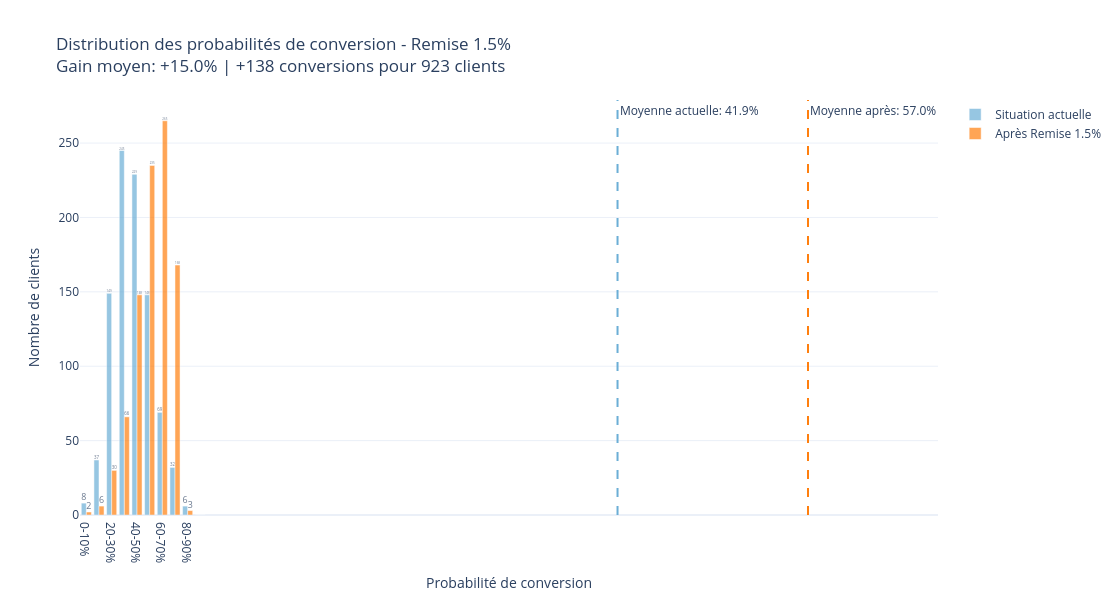


📊 RÉSULTATS - Remise 1.5%:
   Probabilité moyenne actuelle: 0.419
   Probabilité moyenne après:    0.570
   Gain moyen:                    +0.150
   Conversions supplémentaires:   138

TEST DE SCÉNARIOS COMBINÉS


Computing combined scenarios: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [23:05<00:00,  1.50s/it]


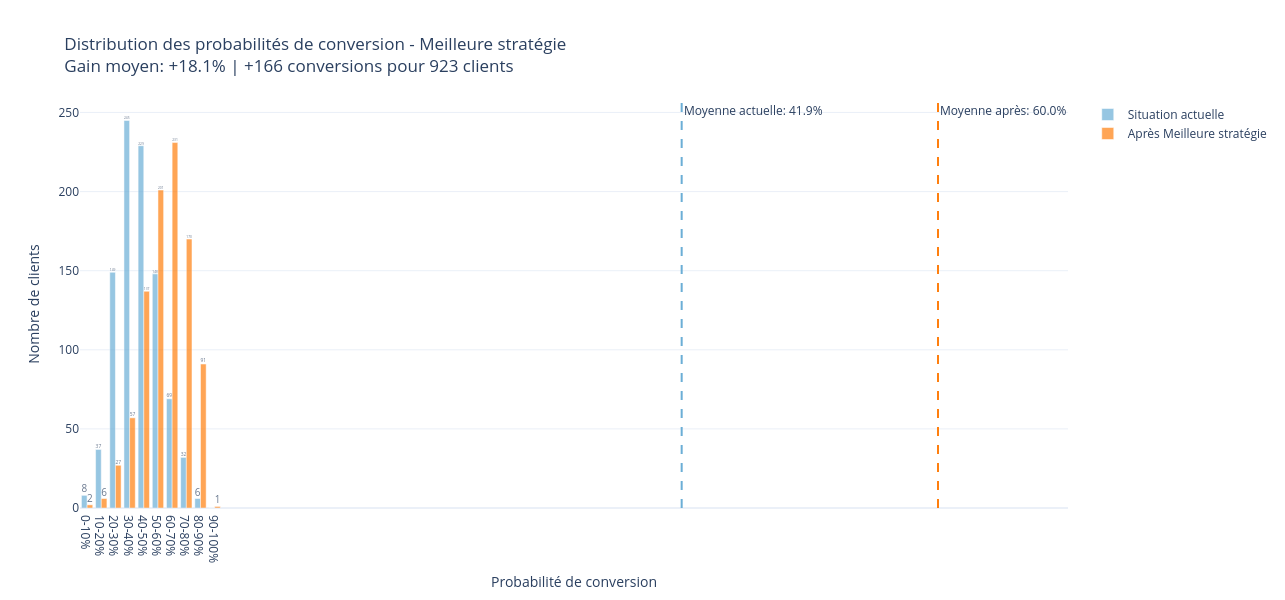


📊 RÉSULTATS - Meilleure stratégie:
   Probabilité moyenne actuelle: 0.419
   Probabilité moyenne après:    0.600
   Gain moyen:                    +0.181
   Conversions supplémentaires:   166


In [9]:
# CONVERSION SHIFT SIMULATION - REUSING YOUR BASE CLASSES
print("\n=== 📈 CONVERSION SHIFT: 1,000 CUSTOMERS ===\n")

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from tqdm import tqdm

from ml_simulation.dataset_split import customer_split
from ml_simulation.data import Simulation
from ml_inference.inference import safe_predict


# ============================================
# SCENARIO-SPECIFIC CHANGE FUNCTIONS
# ============================================

def discount_change(quotes, discount_pct=1.5):
    """Apply strategic discount"""
    modified = quotes.copy()
    price = modified['mt_apres_remise_ht_devis'].sum()
    discount_amount = price * (discount_pct / 100)
    modified['mt_remise_exceptionnelle_ht'] = -discount_amount
    modified['mt_apres_remise_ht_devis'] = price - discount_amount
    return modified

def cross_sell_change(quotes):
    """Add stove to heat pump owners (if applicable)"""
    modified = quotes.copy()
    # Only apply if customer has heat pump
    if 'Pompe à chaleur' in quotes['famille_equipement_produit'].values:
        new_row = modified.iloc[-1:].copy()
        new_row['famille_equipement_produit'] = 'Poêle'
        modified = pd.concat([modified, new_row], ignore_index=True)
    return modified

def follow_up_change(quotes, days=12, discount=50):
    """Add follow-up quote (if single quote)"""
    from datetime import timedelta
    modified = quotes.copy()
    if len(modified) == 1:  # Only apply to single-quote customers
        new_row = modified.iloc[-1:].copy()
        new_row['dt_creation_devis'] = modified['dt_creation_devis'].max() + timedelta(days=days)
        new_row['mt_remise_exceptionnelle_ht'] = -discount
        modified = pd.concat([modified, new_row], ignore_index=True)
    return modified

def price_match_change(quotes, reduction=0.15):
    """Apply price reduction"""
    modified = quotes.copy()
    price = modified['mt_apres_remise_ht_devis'].sum()
    modified['mt_apres_remise_ht_devis'] = price * (1 - reduction)
    return modified

def rep_change(quotes, rep_type='marina'):
    """Apply rep-specific discount"""
    modified = quotes.copy()
    price = modified['mt_apres_remise_ht_devis'].sum()
    
    if rep_type == 'marina':
        discount_pct = 2.5
    elif rep_type == 'elisabeth':
        discount_pct = 0.6
    else:  # clement
        discount_pct = 1.5
        
    discount_amount = price * (discount_pct / 100)
    modified['mt_remise_exceptionnelle_ht'] = -discount_amount
    modified['mt_apres_remise_ht_devis'] = price - discount_amount
    return modified


# ============================================
# CONVERSION SHIFT SIMULATION CLASS
# ============================================

class ConversionShiftSimulation(Simulation):
    """
    Simulates conversion shift on N customers for one or multiple scenarios.
    Inherits from your base Simulation class.
    """
    
    def __init__(self, pred_model, feature_names, safe_predict, df_simulation):
        super().__init__(pred_model, feature_names, safe_predict, df_simulation, sampled_ids=[])
        self.n_customers = 1000
        
    def sample_customers(self, random_state=42):
        """Sample N non-converted customers"""
        sim_conv = self.df_simulation.groupby('numero_compte')['fg_devis_accepte'].max()
        non_converted = sim_conv[sim_conv == 0].index.tolist()
        
        sample_size = min(self.n_customers, len(non_converted))
        random.seed(random_state)
        self.sampled_ids = random.sample(non_converted, sample_size)
        
        print(f"✅ Sampled {len(self.sampled_ids)} non-converted customers")
        return self.sampled_ids
    
    def compute_single_scenario(self, scenario_name, apply_func, **kwargs):
        """Compute baseline and scenario probabilities for all customers"""
        if not self.sampled_ids:
            self.sample_customers()
            
        baseline_probs = []
        scenario_probs = []
        
        for cust_id in tqdm(self.sampled_ids, desc=f"Computing {scenario_name}"):
            quotes = self.df_simulation[self.df_simulation['numero_compte'] == cust_id].copy()
            
            # Baseline
            base_prob = self.safe_predict(cust_id, quotes, self.pred_model, self.feature_names)
            baseline_probs.append(base_prob)
            
            # Apply scenario change
            modified_quotes = apply_func(quotes, **kwargs)
            scen_prob = self.safe_predict(cust_id, modified_quotes, self.pred_model, self.feature_names)
            scenario_probs.append(scen_prob)
            
        return {
            'baseline': np.array(baseline_probs),
            'scenario': np.array(scenario_probs),
            'name': scenario_name
        }
    
    def compute_combined_scenarios(self, scenarios):
        """Compute best of multiple scenarios for each customer"""
        if not self.sampled_ids:
            self.sample_customers()
            
        baseline_probs = []
        best_probs = []
        
        for cust_id in tqdm(self.sampled_ids, desc="Computing combined scenarios"):
            quotes = self.df_simulation[self.df_simulation['numero_compte'] == cust_id].copy()
            
            # Baseline
            base_prob = self.safe_predict(cust_id, quotes, self.pred_model, self.feature_names)
            baseline_probs.append(base_prob)
            
            # Try all scenarios and keep the best
            best = base_prob
            for name, apply_func, kwargs in scenarios:
                modified_quotes = apply_func(quotes.copy(), **kwargs)
                prob = self.safe_predict(cust_id, modified_quotes, self.pred_model, self.feature_names)
                if prob > best:
                    best = prob
                    
            best_probs.append(best)
            
        return {
            'baseline': np.array(baseline_probs),
            'scenario': np.array(best_probs),
            'name': 'Meilleure stratégie'
        }


# ============================================
# VISUALIZATION
# ============================================

def plot_conversion_shift(results, bins=10):
    """Create the distribution comparison plot"""
    
    baseline = results['baseline']
    scenario = results['scenario']
    name = results['name']
    
    # Create bins from 0 to 1
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_labels = [f"{bin_edges[i]*100:.0f}-{bin_edges[i+1]*100:.0f}%" for i in range(bins)]
    
    baseline_hist, _ = np.histogram(baseline, bins=bin_edges)
    scenario_hist, _ = np.histogram(scenario, bins=bin_edges)
    
    baseline_mean = np.mean(baseline)
    scenario_mean = np.mean(scenario)
    lift = scenario_mean - baseline_mean
    additional_conversions = int(lift * len(baseline))
    
    fig = go.Figure()
    
    # Baseline histogram
    fig.add_trace(go.Bar(
        name='Situation actuelle',
        x=bin_labels,
        y=baseline_hist,
        marker_color='#6baed6',
        opacity=0.7,
        text=baseline_hist,
        textposition='auto',
        hovertemplate='Probabilité %{x}<br>Clients: %{y}<extra></extra>'
    ))
    
    # Scenario histogram
    fig.add_trace(go.Bar(
        name=f'Après {name}',
        x=bin_labels,
        y=scenario_hist,
        marker_color='#ff7f0e',
        opacity=0.7,
        text=scenario_hist,
        textposition='auto',
        hovertemplate='Probabilité %{x}<br>Clients: %{y}<extra></extra>'
    ))
    
    # Add vertical lines for means
    fig.add_vline(x=baseline_mean * 100, line_dash='dash', line_color='#6baed6',
                  annotation_text=f"Moyenne actuelle: {baseline_mean:.1%}")
    fig.add_vline(x=scenario_mean * 100, line_dash='dash', line_color='#ff7f0e',
                  annotation_text=f"Moyenne après: {scenario_mean:.1%}")
    
    fig.update_layout(
        title=f"Distribution des probabilités de conversion - {name}<br>"
              f"Gain moyen: {lift:+.1%} | +{additional_conversions} conversions pour {len(baseline)} clients",
        xaxis_title="Probabilité de conversion",
        yaxis_title="Nombre de clients",
        barmode='group',
        template='plotly_white',
        height=600,
        hovermode='x'
    )
    
    return fig


# ============================================
# MAIN EXECUTION
# ============================================

# 1. Get your model and data (already in your notebook)
# model, feature_names, df_sim are already defined

# 2. Create simulation instance
sim = ConversionShiftSimulation(model, feature_names, safe_predict, df_sim)

# 3. Sample 1000 customers
sim.sample_customers(random_state=42)

# 4. Test single scenario (e.g., Discount)
print("\n" + "="*60)
discount_results = sim.compute_single_scenario(
    "Remise 1.5%", 
    discount_change, 
    discount_pct=1.5
)

# 5. Plot
fig = plot_conversion_shift(discount_results)
fig.show()

# 6. Print summary statistics
print(f"\n📊 RÉSULTATS - {discount_results['name']}:")
print(f"   Probabilité moyenne actuelle: {np.mean(discount_results['baseline']):.3f}")
print(f"   Probabilité moyenne après:    {np.mean(discount_results['scenario']):.3f}")
print(f"   Gain moyen:                    {np.mean(discount_results['scenario']) - np.mean(discount_results['baseline']):+.3f}")
print(f"   Conversions supplémentaires:   {int((np.mean(discount_results['scenario']) - np.mean(discount_results['baseline'])) * len(discount_results['baseline']))}")

# 7. Test multiple scenarios (optional)
print("\n" + "="*60)
print("TEST DE SCÉNARIOS COMBINÉS")
print("="*60)

scenarios = [
    ("Remise 1.5%", discount_change, {'discount_pct': 1.5}),
    ("Cross-sell Poêle", cross_sell_change, {}),
    ("Suivi J+12", follow_up_change, {'days': 12, 'discount': 50}),
    ("MARINA (2.5%)", rep_change, {'rep_type': 'marina'}),
]

combined_results = sim.compute_combined_scenarios(scenarios)
fig2 = plot_conversion_shift(combined_results)
fig2.show()

print(f"\n📊 RÉSULTATS - {combined_results['name']}:")
print(f"   Probabilité moyenne actuelle: {np.mean(combined_results['baseline']):.3f}")
print(f"   Probabilité moyenne après:    {np.mean(combined_results['scenario']):.3f}")
print(f"   Gain moyen:                    {np.mean(combined_results['scenario']) - np.mean(combined_results['baseline']):+.3f}")
print(f"   Conversions supplémentaires:   {int((np.mean(combined_results['scenario']) - np.mean(combined_results['baseline'])) * len(combined_results['baseline']))}")